# Anomaly detection via autoencoder

To open this notebook and generate these plots, first clone the repo. Now open the terminal and move to the repo folder. Then run this command to open this notebook in a Jupyterlab running in a docker container ([Docker Engine](https://docs.docker.com/install/) must be already installed on your machine):

`docker run --rm -p 10000:8888 -e JUPYTER_ENABLE_LAB=yes -v "$PWD":/home/jovyan/work arashsaeidpour/fabjupyterlab:plotly`

Now open your browser and type in this address to open the jupyterlab:

`localhost:10000`

Copy paste the token from the terminal window to log in. Now move to `/work/src/` to find this notebook. 

## Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

#import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import LSTM,CuDNNLSTM
#from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.optimizers import Adam,Adamax
from keras import regularizers
from keras import backend as K
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import r2_score

from numpy.random import seed
seed(1)


SEED = 123 
DATA_SPLIT_PCT = 0.2

#rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

from matplotlib import rc
from pylab import rcParams
rcParams['figure.figsize'] = 22, 10
%matplotlib inline
%config InlineBackend.figure_format='retina'


from pandas.plotting import register_matplotlib_converters
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [3]:
plt.style.use('seaborn-bright')
perso_linewidth = 0.3
# This will change your default rcParams
def init_plotting():
    plt.rcParams['figure.figsize'] = (6.5,6.5)
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    #plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['figure.dpi']= 150
    plt.rcParams['axes.linewidth'] = perso_linewidth
    plt.rcParams['savefig.dpi'] = '300'
    plt.rcParams['savefig.format'] = 'pdf'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = '0'
    plt.rcParams['axes.grid'] = False
    plt.rcParams['grid.color']='white'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = '0.4'
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams['legend.edgecolor'] = 'black'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['lines.markersize']= 2.3 
    plt.rcParams['lines.markeredgewidth']= '0.1'
    plt.rcParams['lines.color']= 'r' 
    plt.rcParams['lines.marker']= '' 
    plt.rcParams['lines.linestyle']= '-' 
    plt.rcParams['xtick.color']= 'black'
    plt.rcParams['ytick.color']= 'black'
    #plt.rcParams['axes.color_cycle']= ['#3778bf', '#feb308', '#a8a495', '#7bb274', '#825f87']
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['right'].set_visible('False')
    plt.gca().spines['top'].set_visible('False')
    plt.gca().spines['top'].set_color('none')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.rcParams['ytick.minor.size']= 1.5
    plt.rcParams['ytick.major.width']= perso_linewidth
    plt.rcParams['ytick.minor.width']= perso_linewidth
    plt.rcParams['xtick.major.width']= perso_linewidth
    plt.rcParams['xtick.minor.width']= perso_linewidth

init_plotting()

plt.close()

### Centering the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
df_B = pd.read_pickle('../00-RawData/FluView_current/Pickled_dfs/df_B_over_total_samples.pickle')
df_B.index = pd.to_datetime(df_B.index)

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

## Discarding all-zero states

In [6]:
df_B = df_B.loc[:,df_B.sum()>0]

In [7]:
time_steps=52
X_all = np.empty([0,time_steps,1])
for state in df_B.columns:
    X_state,_ = create_dataset(df_B[[state]], df_B[state], time_steps=time_steps)
    X_all = np.append(X_all,X_state,axis=0)  

In [8]:
X_train, X_val, _, _ = train_test_split(X_all,X_all,test_size=0.2,random_state=10,shuffle=True)

In [9]:
nb_epoch = 128
batch_size = 128
hidden_dim = 3
learning_rate = 1e-3

# Autoencoder  Summary

In [10]:
autoencoder = Sequential()
autoencoder.add(CuDNNLSTM(32, input_shape=(time_steps,X_train.shape[2]),return_sequences=True))
autoencoder.add(Dropout(0.3))
autoencoder.add(CuDNNLSTM(hidden_dim))
autoencoder.add(RepeatVector(time_steps))
autoencoder.add(CuDNNLSTM(32 , return_sequences=True))
autoencoder.add(CuDNNLSTM(64, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(X_train.shape[2])))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 52, 32)            4480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 32)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 3)                 444       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 52, 3)             0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 52, 32)            4736      
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 52, 64)            25088     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 52, 1)            

In [43]:
optimizer = Adam(learning_rate=learning_rate,clipnorm=1.,amsgrad=True)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer=optimizer)

cp = ModelCheckpoint(filepath="LSTM_autoencoder_model_weights/model_weights_temporal_states.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./tboard_log',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [ ]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[cp,tb]).history

# AE learning curve

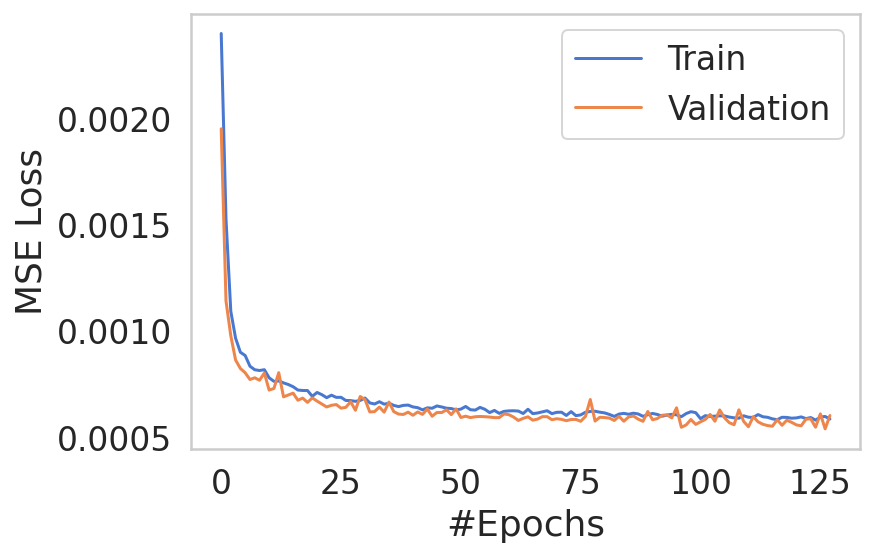

In [356]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('#Epochs')
plt.ylabel('MSE Loss')
plt.grid(False)
plt.legend();

In [12]:
state = 'Minnesota'
X_state,_ = create_dataset(df_B[[state]], df_B[state], time_steps=time_steps)
X_state_pred = autoencoder.predict(X_state)

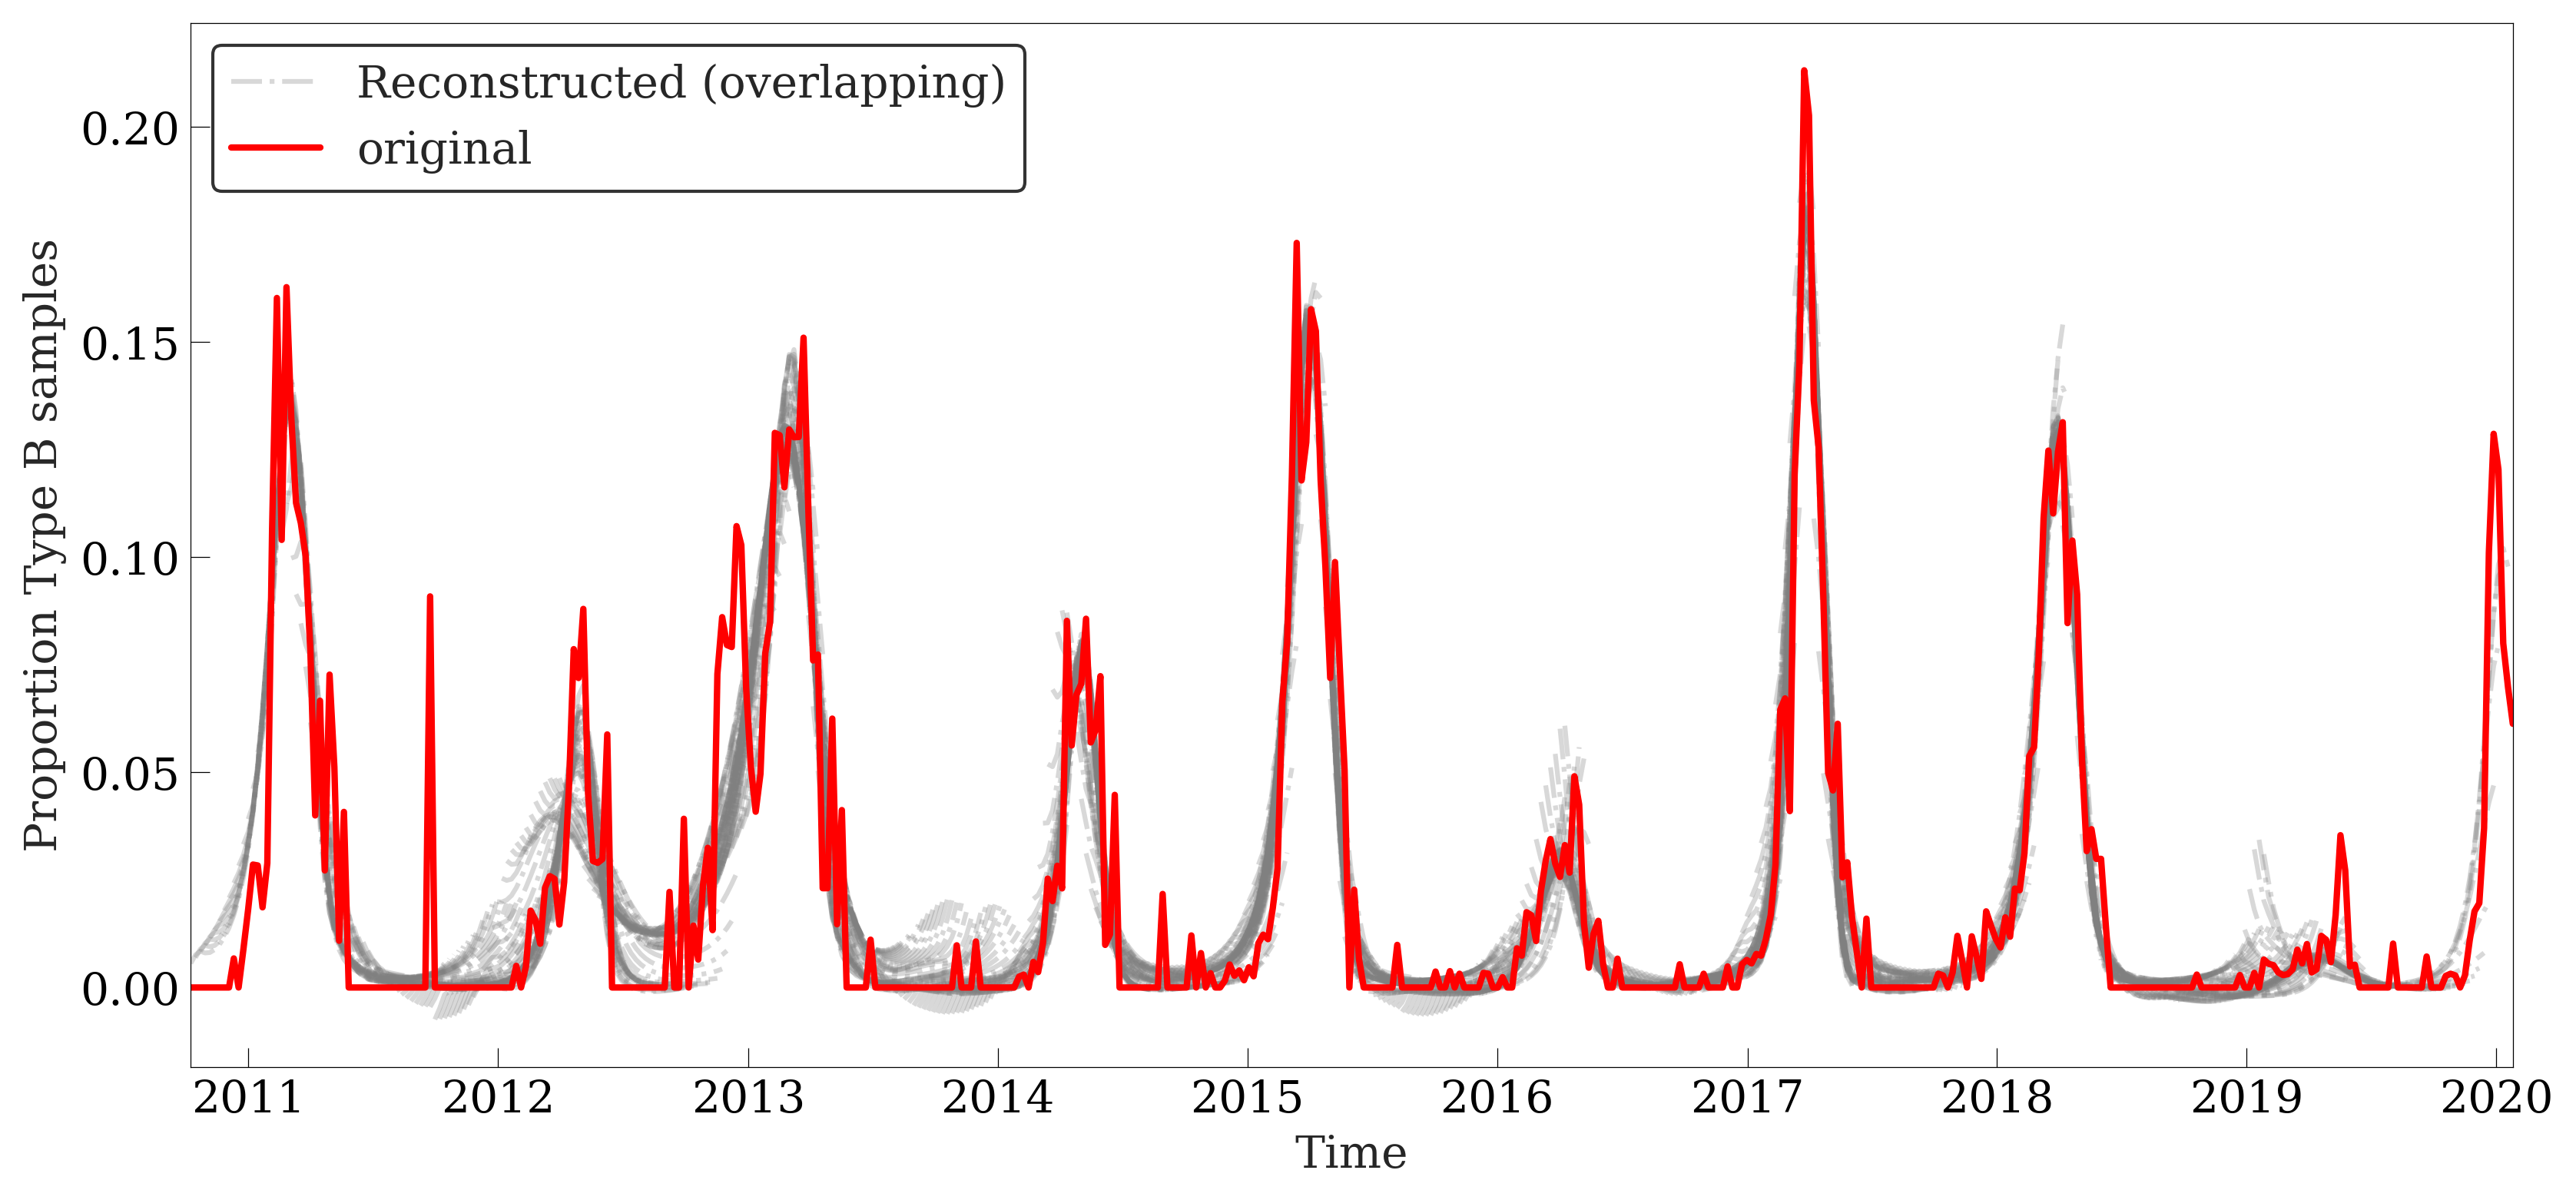

In [85]:
ig,ax = plt.subplots(1,1,figsize=(6.5*2,3*2))
i_sample =130




label='Reconstructed (overlapping)'
for i in range(X_state.shape[0]):
    idx = df_B.index[i:i+time_steps]
    ax.plot(idx,X_state_pred[i,:,:],color='gray',alpha=0.3,linestyle='-.',label=label)
    label=None
    
ax.plot(df_B[state],color='red',linewidth=2,label='original')  
    
ax.set_xlabel('Time')
ax.set_ylabel('Proportion Type B samples')
    
ax.grid(False)
ax.tick_params(axis='x',direction='in',bottom=True)
ax.tick_params(axis='y',direction='in',left=True)
ax.set_xlim((df_B.index[0],df_B.index[-1]))
ax.legend()

#plt.savefig(f'paper_output/{state}_recons_time_series.pdf',dpi=300,bbox_inches='tight',pad_inche=0)
plt.show()

In [13]:
idx_nonzero = np.argwhere(X_all.squeeze().sum(axis=1)!=0).squeeze()
X_all_nonzero = X_all[idx_nonzero,:,:]
X_all_nonzero_pred = autoencoder.predict(X_all_nonzero)
rmsd_all = np.sqrt(((X_all_nonzero - X_all_nonzero_pred)**2).mean(axis=1))
nrmsd_all = rmsd_all / (X_all_nonzero.mean(axis=1))


rmsd_state = np.sqrt(((X_state - X_state_pred)**2).mean(axis=1))
nrmsd_state = rmsd_state / (X_state.mean(axis=1))

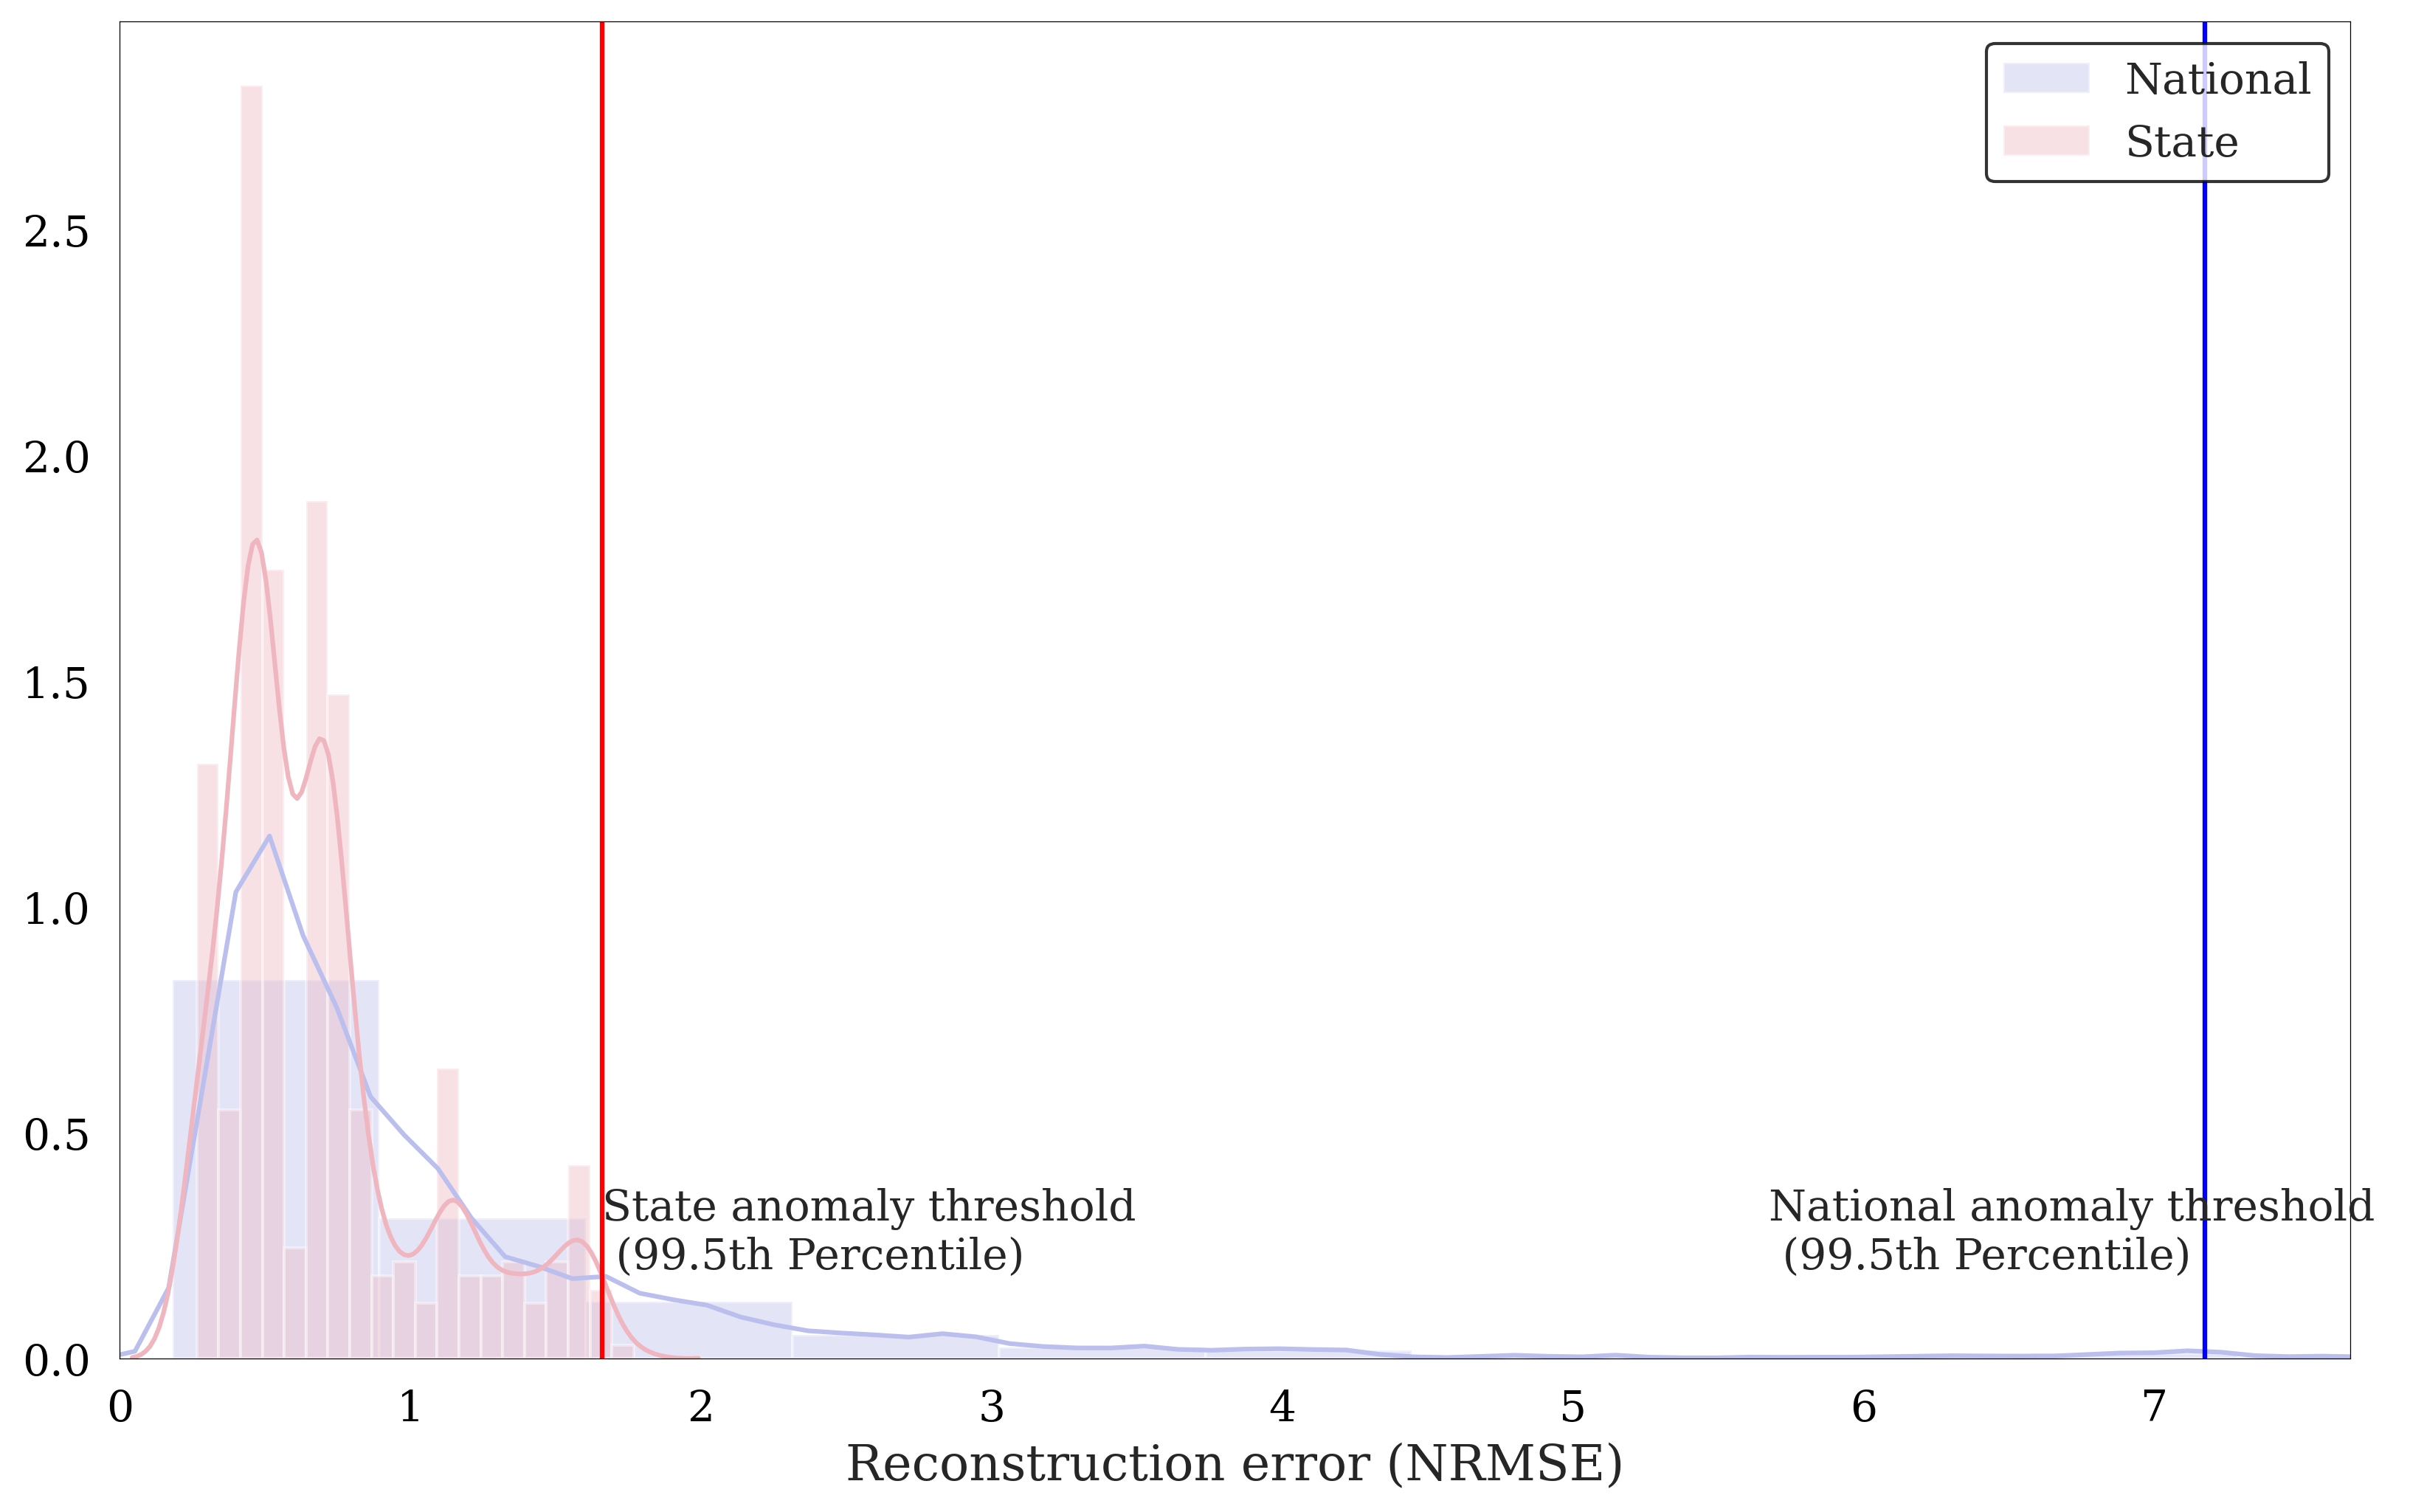

In [14]:
percentile_threshold = 99.5
national_threshold = np.percentile(nrmsd_all,percentile_threshold)
state_threshold = np.percentile(nrmsd_state,percentile_threshold)


fig,ax = plt.subplots(1,1,figsize=(6.5*2,4*2))
sns.distplot(nrmsd_all, bins=20, kde=True,rug=False,ax=ax,color='#BBBFED',label='National')
sns.distplot(nrmsd_state, bins=20, kde=True,rug=False,ax=ax,color='#EFB6C0',label='State')


ax.axvline(national_threshold,color='blue')
ax.axvline(state_threshold,color='red')
ax.text(national_threshold-1.5,0.2,'National anomaly threshold \n ('+str(percentile_threshold) + 'th' + ' Percentile)')
ax.text(state_threshold,0.2,'State anomaly threshold \n ('+str(percentile_threshold) + 'th' + ' Percentile)')
ax.set_xlabel('Reconstruction error (NRMSE)',fontsize=16);
ax.set_xlim(left=0,right=np.percentile(nrmsd_all,99.9));

ax.grid(False)
ax.legend(loc=1)
#plt.savefig(f'paper_output/{state}_distribution_reconst_error.pdf',dpi=300,bbox_inches='tight',pad_inche=0)
plt.show()

In [15]:
df_error = pd.DataFrame(data=nrmsd_state,index=df_B.index[time_steps:X_state.shape[0]+time_steps])

In [16]:
percentile_threshold = 99.5
national_threshold = np.percentile(nrmsd_all,percentile_threshold)

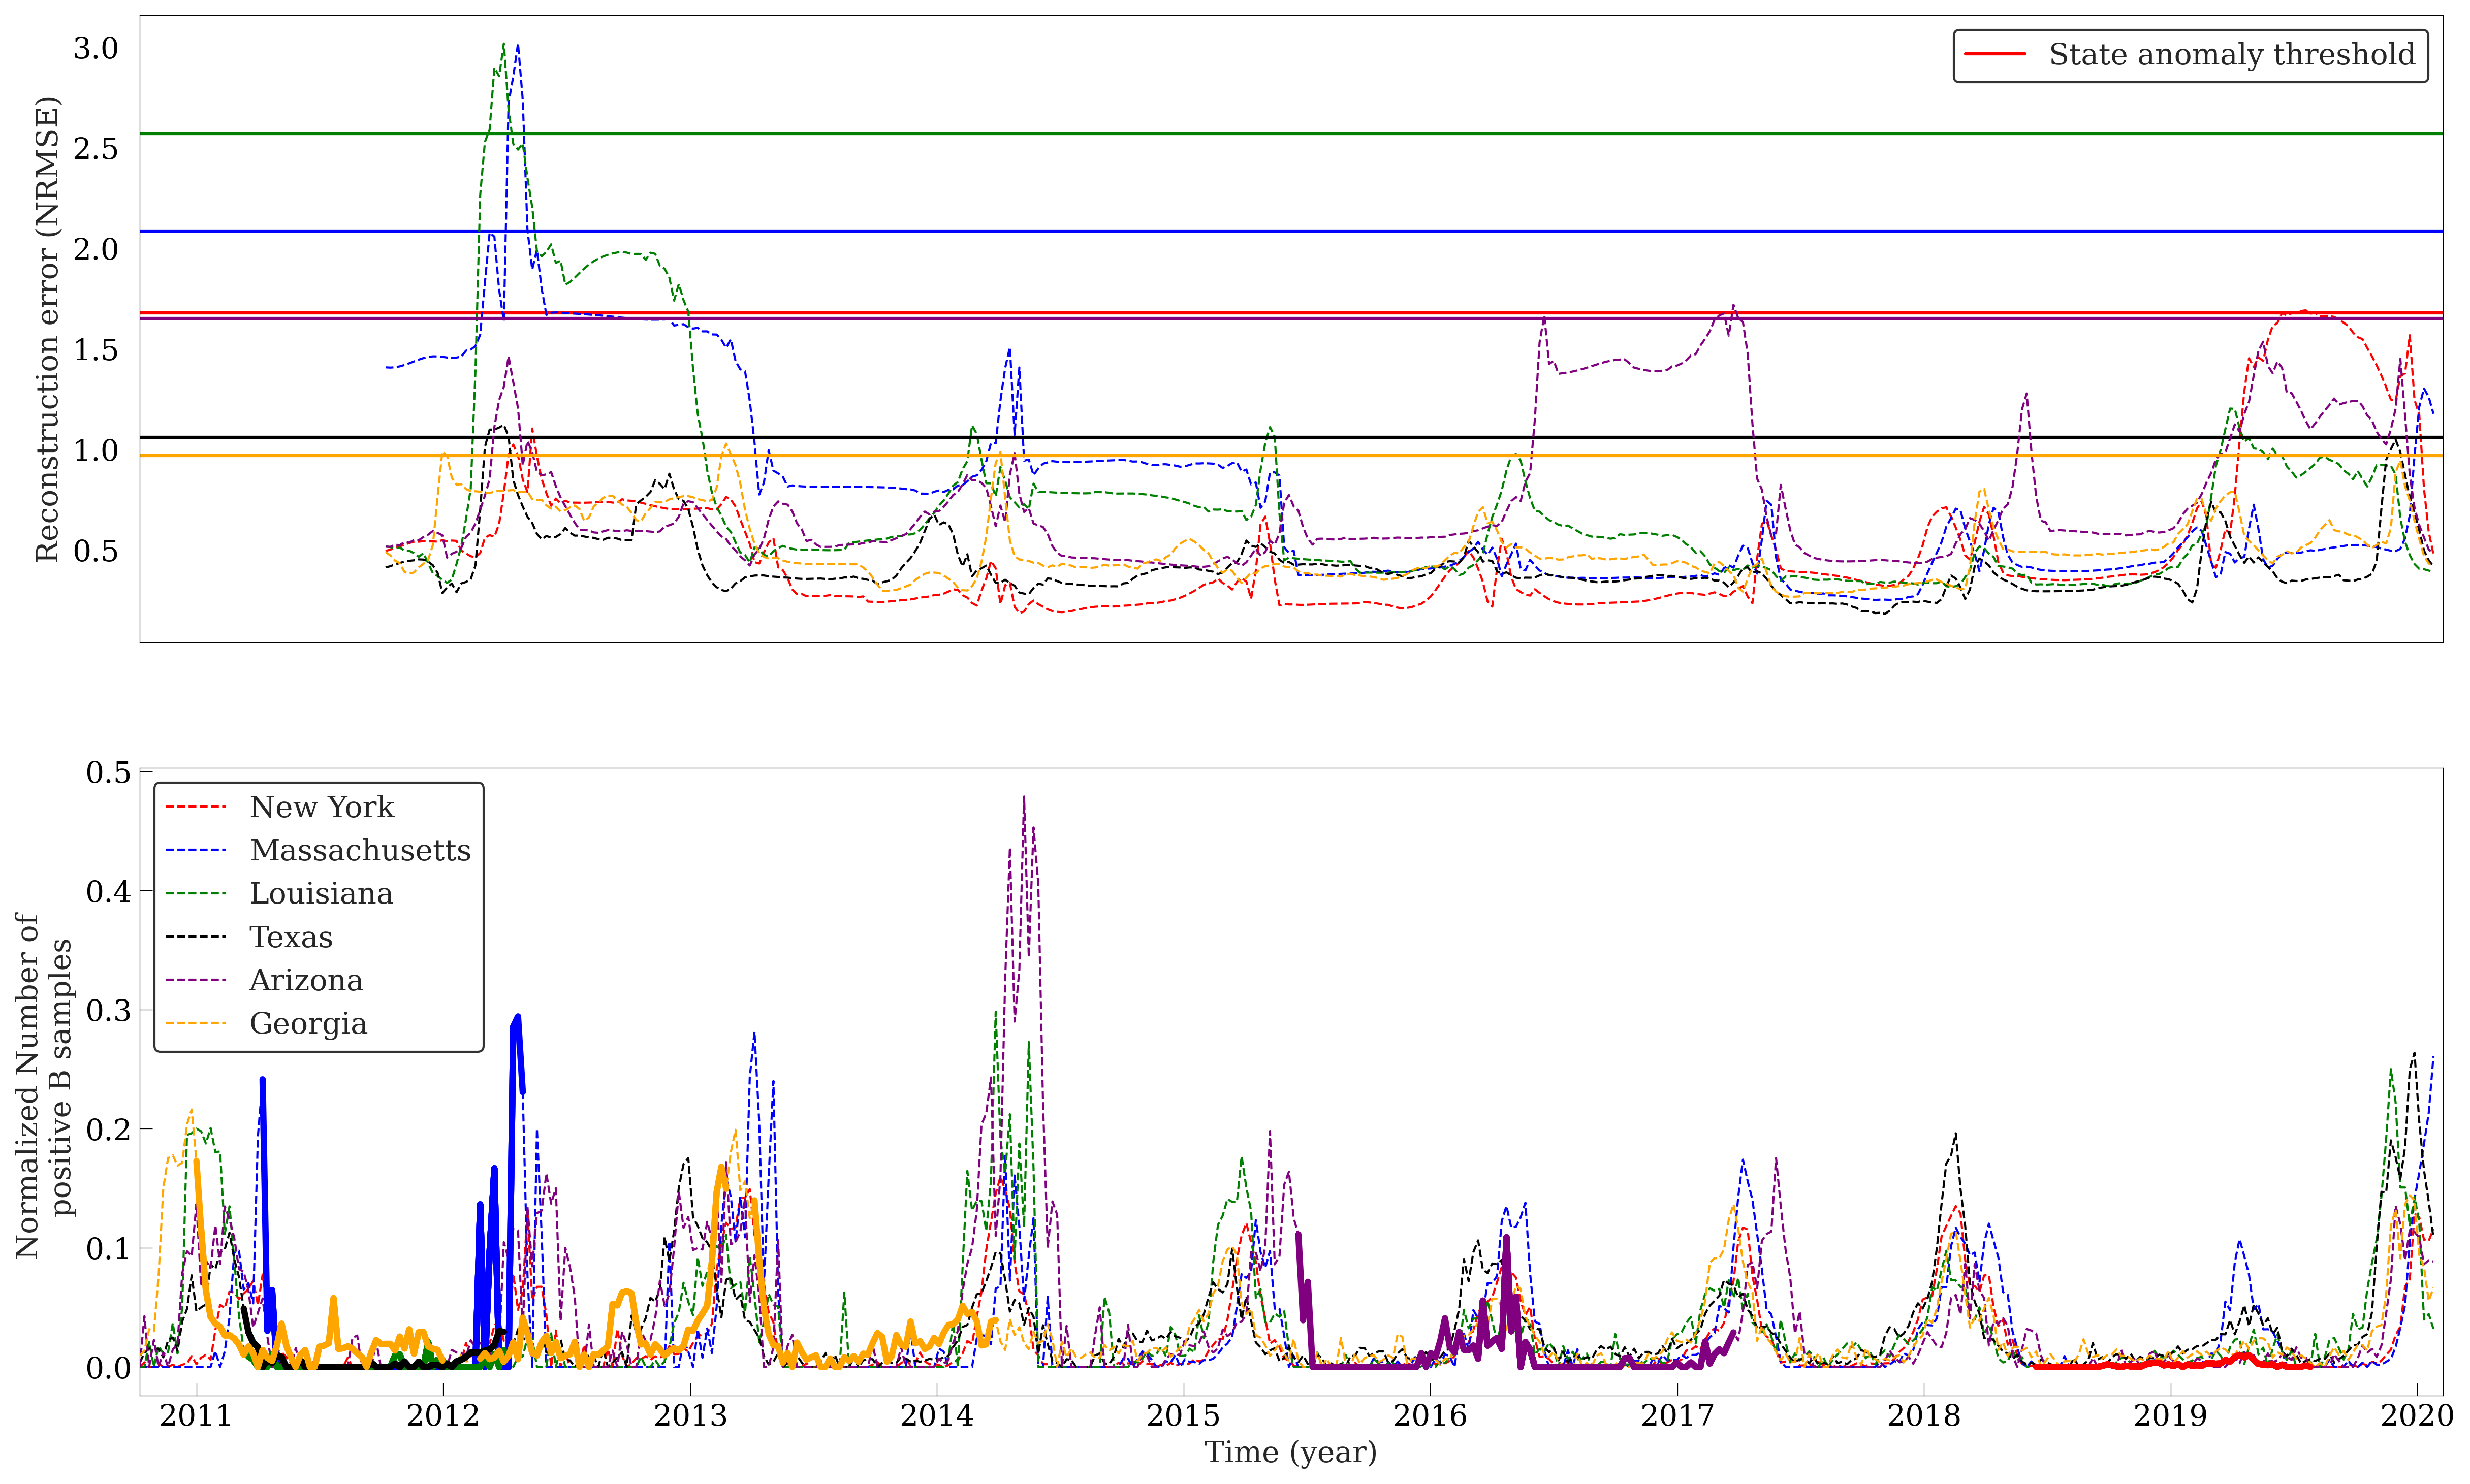

In [53]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(6.5*3,4*3),sharex=True)
percentile_threshold = 99.0
cmap = mpl.cm.get_cmap('Set1')
first_occurence_label1 = 'State anomaly threshold'
colors = ['red','blue','green','black','purple','orange']
for i,state in enumerate(['New York','Massachusetts','Louisiana','Texas','Arizona','Georgia']):
    X_state,_ = create_dataset(df_B[[state]], df_B[state], time_steps=time_steps)
    X_state_pred = autoencoder.predict(X_state)
    rmsd_state = np.sqrt(((X_state - X_state_pred)**2).mean(axis=1))
    nrmsd_state = rmsd_state / (X_state.mean(axis=1))
    nrmsd_state[nrmsd_state==np.inf] = 0
    state_threshold = np.percentile(nrmsd_state,percentile_threshold)
    
    df_error = pd.DataFrame(data=nrmsd_state,index=df_B.index[time_steps:X_state.shape[0]+time_steps])
    

    color = colors[i]#cmap(i/6)
    
    ax1.plot(df_error,color=color,linestyle='--',linewidth=1.0)
    ax1.axhline(df_error.quantile(percentile_threshold/100)[0],color=color,label=first_occurence_label1)
    first_occurence_label1 = None

    ax2.plot(df_B[state],color=color,alpha=1.0,zorder=0,label=state,linestyle='--',linewidth=1.0)

    

    for i in range(df_error.shape[0]):
        if df_error.iloc[i,0]>state_threshold:
            i_end= i + time_steps
            ax2.plot(df_B[state].index[i:i_end],df_B[state].iloc[i:i_end],
                     color=color,alpha=1,
                     zorder=1,linewidth=3,
                     label=first_occurence_label2)
            
        
            

ax2.set_ylabel('Normalized Number of \n positive B samples')
ax2.set_xlabel('Time (year)')
ax1.set_ylabel('Reconstruction error (NRMSE)')

ax2.set_xlim((df_B.index[0],df_B.index[-1]+pd.Timedelta(14,unit='D')))



ax2.grid(False)
ax2.tick_params(axis='x',direction='in',bottom=True)
ax2.tick_params(axis='y',direction='in',left=True)
ax1.legend()
ax2.legend(loc=2);


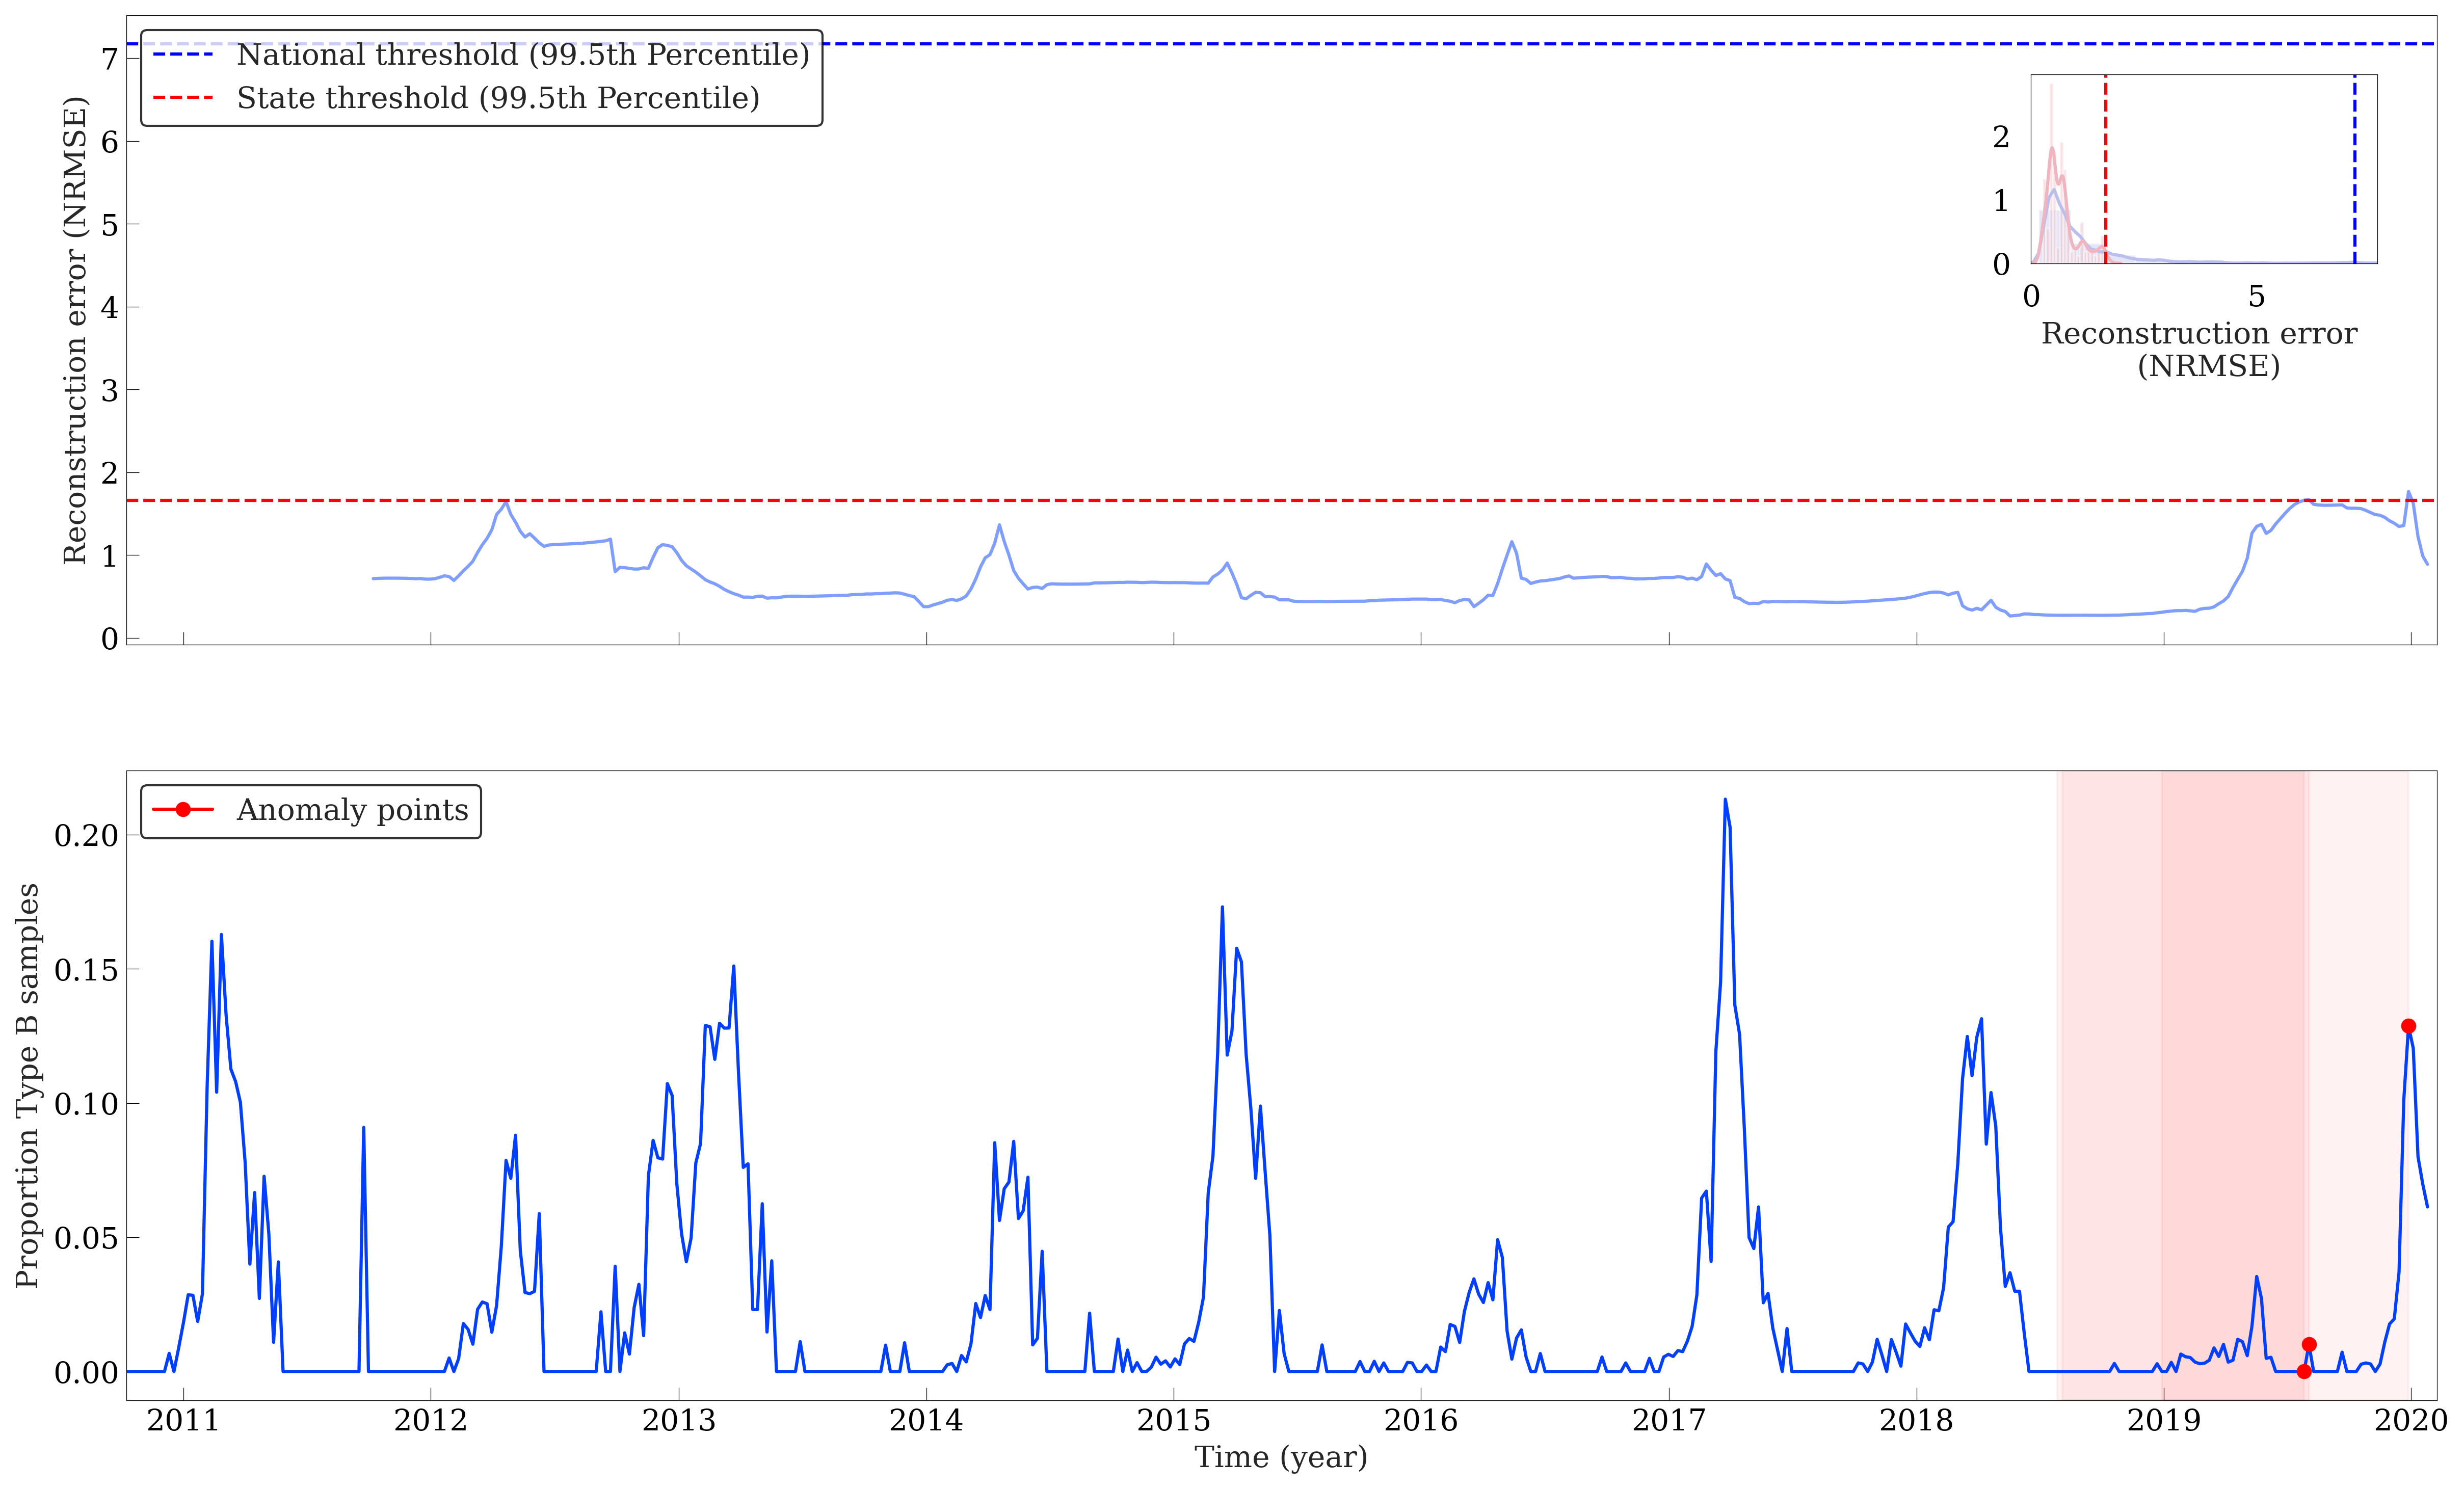

In [90]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(6.5*3,4*3),sharex=True)
ax1.plot(df_error,alpha=0.5)
ax1.set_ylabel('Reconstruction error (NRMSE)')
ax1.axhline(national_threshold,linestyle='--',color='blue',label='National threshold (99.5th Percentile)')
ax1.axhline(state_threshold,linestyle='--',color='red',label='State threshold (99.5th Percentile)')


ax2.plot(df_B[state])

#ax2 = ax.twinx()

label='Anomaly points'
for i in range(df_error.shape[0]):
    if df_error.iloc[i,0]>state_threshold:
        
        ax2.plot(df_B[state].index[i+time_steps],df_B[state].iloc[i+time_steps],color='red',marker='o',label=label,markersize=7)
        
        ax2.axvspan(df_B[state].index[i],df_B[state].index[i+time_steps],color='red',alpha=0.05)
        label=None

ax2.set_ylabel('Proportion Type B samples')
ax2.set_xlabel('Time (year)');

ax2.set_xlim((df_B.index[0],df_B.index[-1]+pd.Timedelta(14,unit='D')))
ax1.legend(loc=2)
#plt.savefig('autoencoder_anomaly_points.png',dpi=300,bbox_inches='tight',pad_inche=0)
ax1.grid(False)
ax1.tick_params(axis='x',direction='in',bottom=True)
ax1.tick_params(axis='y',direction='in',left=True)


ax2.grid(False)
ax2.tick_params(axis='x',direction='in',bottom=True)
ax2.tick_params(axis='y',direction='in',left=True)
ax2.legend(loc=2)


state_threshold = np.percentile(nrmsd_state,percentile_threshold)


ax_error_distribution =  inset_axes(ax1, width="15%", height="30%", loc=1,borderpad=2)
sns.distplot(nrmsd_all, bins=20, kde=True,rug=False,ax=ax_error_distribution,color='#BBBFED')
sns.distplot(nrmsd_state, bins=20, kde=True,rug=False,ax=ax_error_distribution,color='#EFB6C0')


ax_error_distribution.axvline(national_threshold,color='blue',linestyle='--')
ax_error_distribution.axvline(state_threshold,color='red',linestyle='--')

ax_error_distribution.set_xlabel('Reconstruction error \n (NRMSE)');
ax_error_distribution.set_xlim(left=0,right=np.percentile(nrmsd_all,99.9));

ax_error_distribution.grid(False)
#plt.savefig(f'paper_output/{state}_anomalous_segments.pdf',dpi=300,bbox_inches='tight',pad_inche=0)
plt.show()


## Crossing the anomaly threshold

In [17]:
X_all_pred = autoencoder.predict(X_all)

In [18]:
mean_X_all = X_all.mean(axis=1)
mean_X_all[mean_X_all==0]= 999

In [19]:
rmsd_all = np.sqrt(((X_all - X_all_pred)**2).mean(axis=1))
nrmsd_all = rmsd_all / mean_X_all

In [20]:
nrmsd_matrix = nrmsd_all.reshape(-1,49)
df_nrmsd = pd.DataFrame(data=nrmsd_matrix,
                        columns=df_B.columns,
                        index=df_B.index[time_steps:X_state.shape[0]+time_steps])

In [21]:
percentile_threshold = 0.995
df_threshold_by_state = df_nrmsd.quantile(q=percentile_threshold,axis=0)
df_crossing = df_nrmsd - df_threshold_by_state
df_crossing[df_crossing>=0] = 1
df_crossing[df_crossing<0] = 0

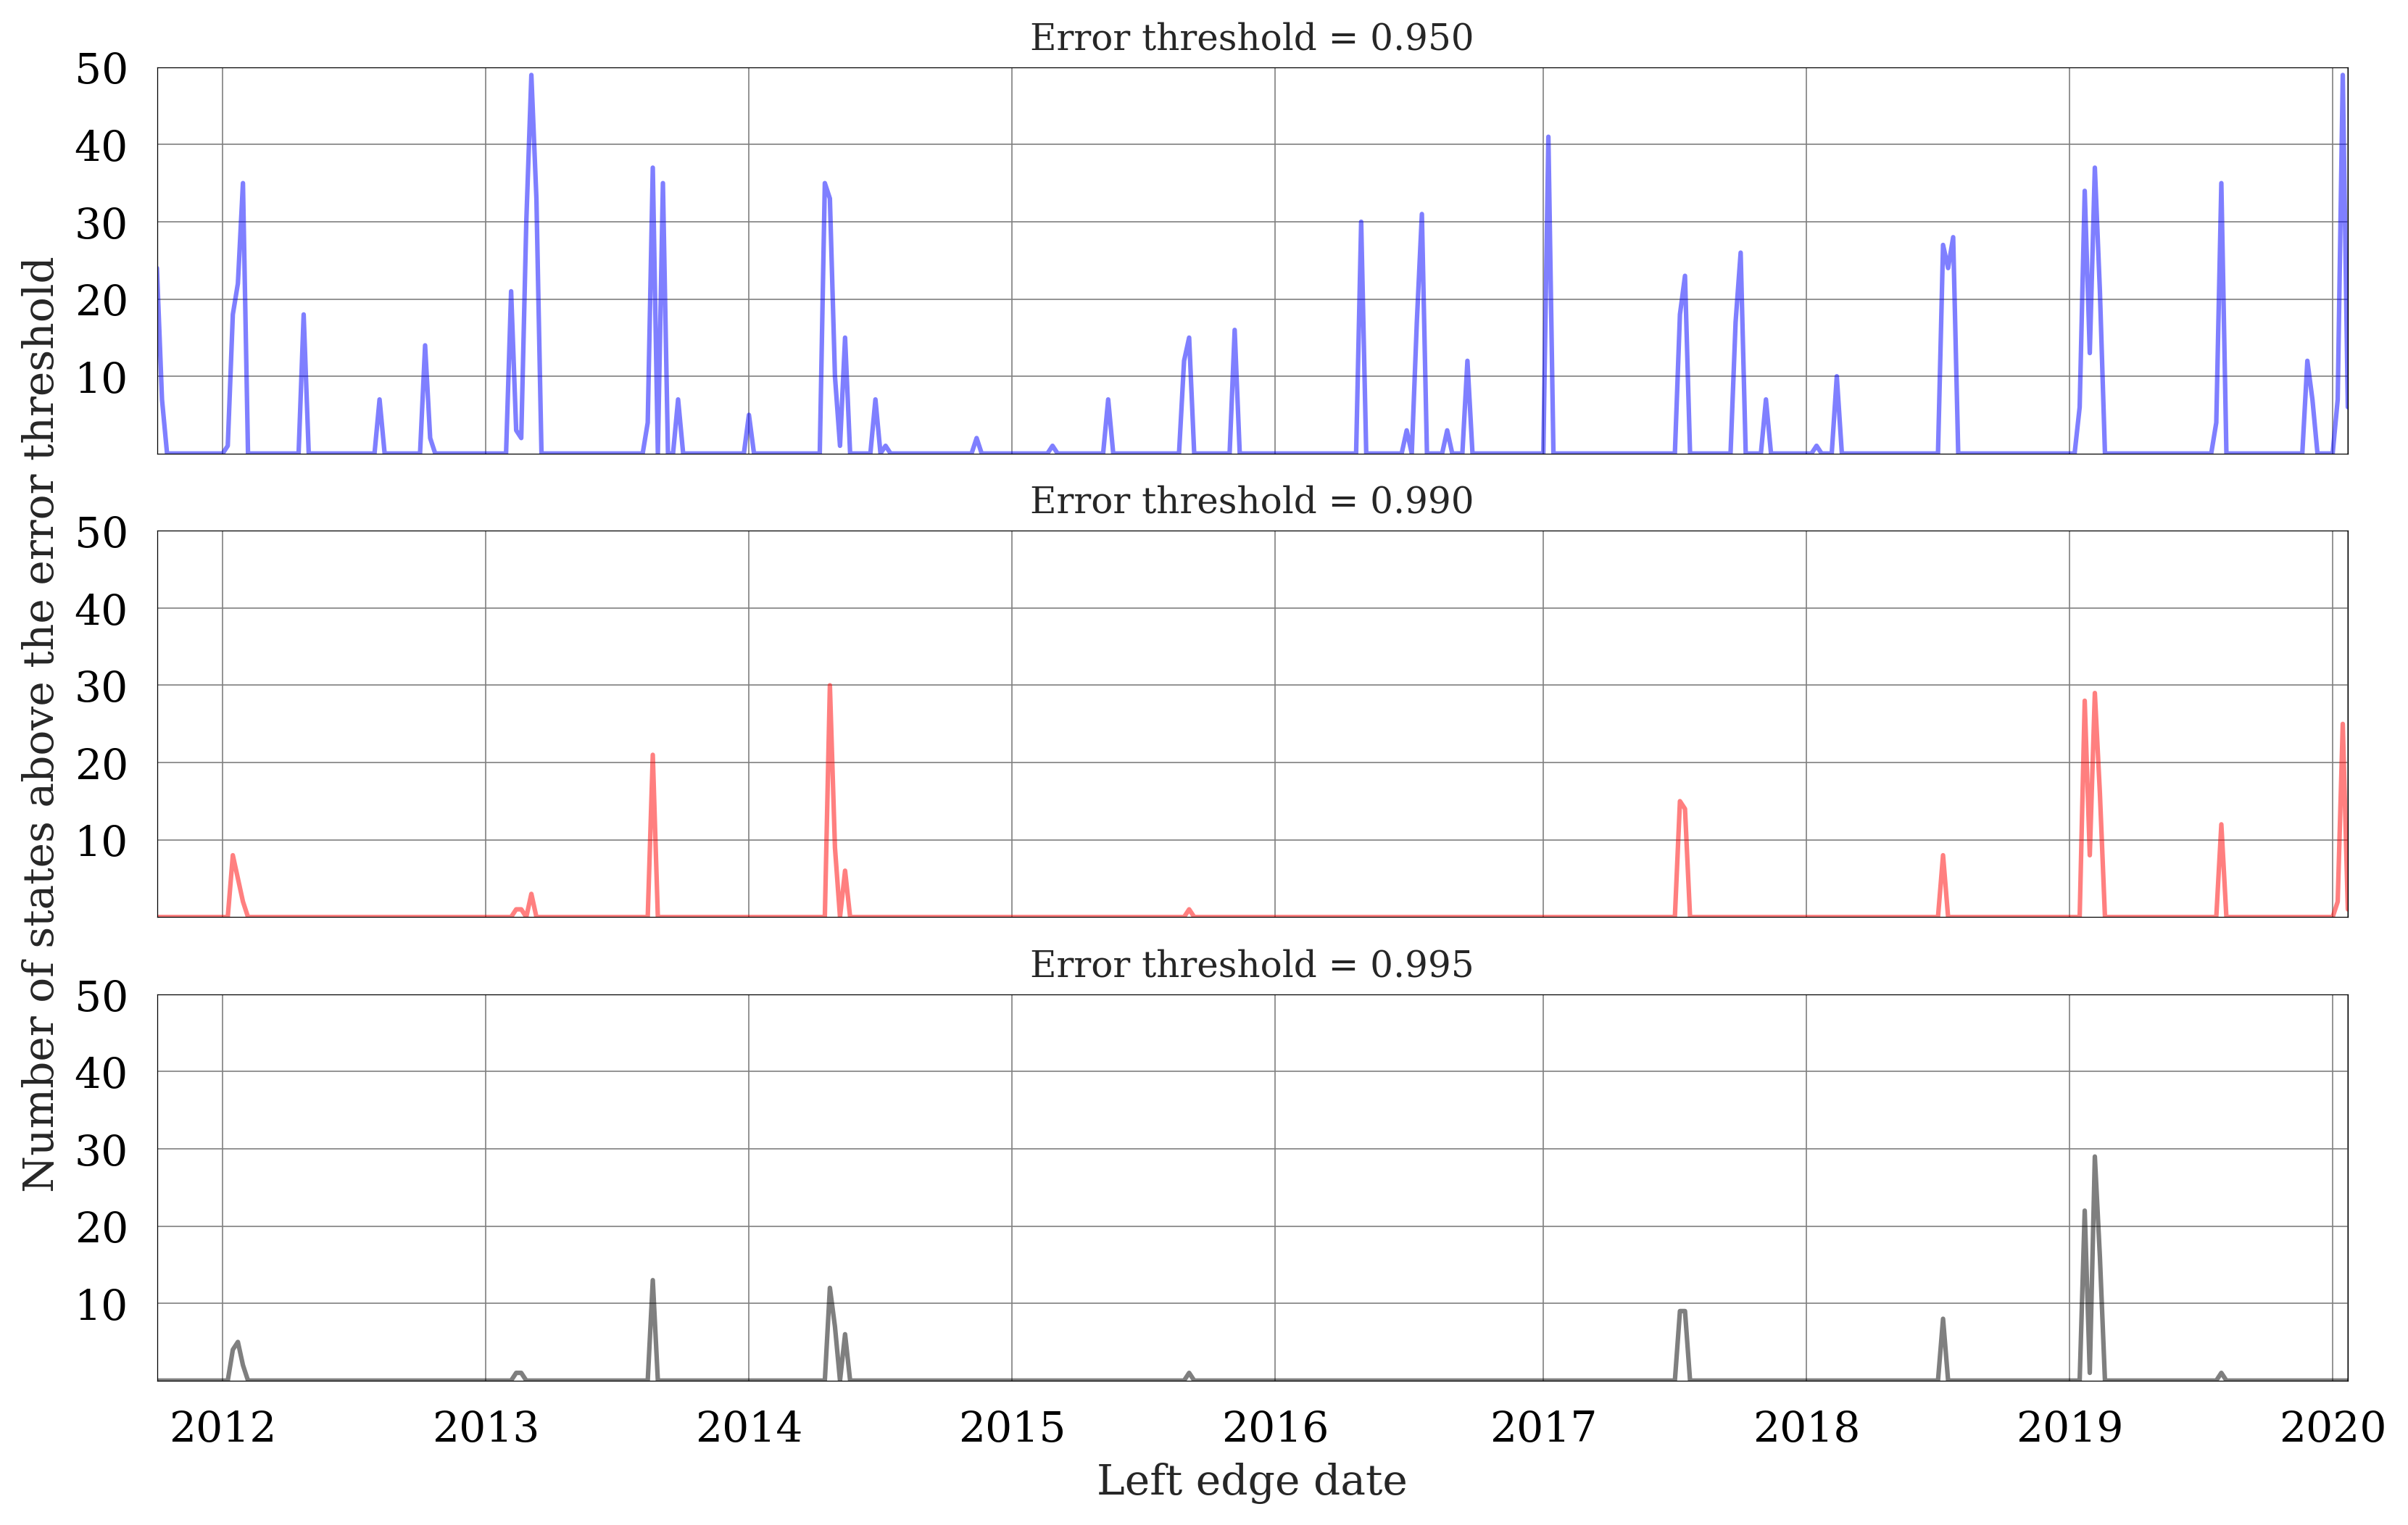

In [23]:
fig,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6.5*2,4*2),sharex=True)
axes = [ax1,ax2,ax3]
cmap = plt.get_cmap('gray', 2)
for percentile_threshold,color,ax in zip([0.95,0.99,0.995],['blue','red','black'],axes):
    df_threshold_by_state = df_nrmsd.quantile(q=percentile_threshold,axis=0)
    df_crossing = df_nrmsd - df_threshold_by_state
    df_crossing[df_crossing>=0] = 1
    df_crossing[df_crossing<0] = 0
    df_crossing.sum(axis=1).plot(ax=ax,color=color,alpha=0.5)
    ax.set_ylim((0,50))
    ax.set_title('Error threshold = %.3f'%percentile_threshold,fontsize=12)
    ax.set_yticks([10,20,30,40,50])
    ax.grid(True,which='major',axis='both',color='gray', linestyle='-')
ax2.set_ylabel('Number of states above the error threshold')
ax3.set_xlabel('Left edge date')
# plt.savefig(f'paper_output/n_state_above_thresholds.pdf',dpi=300,bbox_inches='tight',pad_inche=0)
plt.show()

Fig. X. Number of states going above the reconstruction error threshold for different threshold values 